<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Segment customers of a website - P5</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">| Modeling notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.express as px
import squarify
from statsmodels.graphics.gofplots import qqplot

## df_analysis
import io
import gc
import timeit
import math
from math import pi
from collections import Counter
from math import prod
import scipy.stats as stats

## Scikit Learn 
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer, RobustScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, silhouette_samples

## Yellowbrick - Scikit Learn 
from yellowbrick.cluster import intercluster_distance

# Own specific functions 
from functions import *

%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h3>
</div>

In [2]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
            
        if type_analysis == "summarized":
            print("\n")
        
        if type_analysis is None or type_analysis != "summarized":
            pd.set_option("display.max_rows", None) # show full of showing rows
            pd.set_option("display.max_columns", None) # show full of showing cols
            pd.set_option("display.max_colwidth", None) # show full width of showing cols
            pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    
            
            if type_analysis is None or type_analysis != "complete":
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            elif type_analysis == "complete" and (df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0):
                df_resume["unique"] = list(df.nunique())
                df_desc = pd.DataFrame(df.describe().T).reset_index()
                df_desc = df_desc.rename(columns={"index": "name"})
                df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
                df_resume = df_resume[ORDERING_COMPLETE]
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            
            display(df_resume.sort_values("records", ascending=False))
            
            pd.reset_option("display.max_rows") # reset max of showing rows
            pd.reset_option("display.max_columns") # reset max of showing cols
            pd.reset_option("display.max_colwidth") # reset width of showing cols
            pd.reset_option("display.float_format") # reset show full content in cell
            
        # deleting dataframe to free memory
        if type_analysis == "complete":
            
            if df.select_dtypes(["int64"]).shape[1] > 0 or df.select_dtypes(["float64"]).shape[1] > 0:
                del [[df_resume, df_desc]]
            else:
                del [[df_resume]]
            
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()
            

def normality_test(df):
    """
    Method used to make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64" or df[col].dtypes == "int64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})
    
    display(df_normality_test)
    
            
def number_of_cluster(df, name_df):
    """
    Method used to calculate the number of cluster through differents metrics

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        
        Metrics:
        -----------------
            WSSE (dict): Within-Cluster-Sum of Squared Errors. Number of cluster by iteration
            davies_bouldin (dict): Davies-Bouldin score. Number of cluster by iteration
            silhouette (dict): The mean Silhouette Coefficient of all samples. Number of cluster by iteration
        
        Returns:
    -----------------
        None. 
        Plot the result. 
    """
    
    WSSE, davies_bouldin, silhouette = ({} for i in range(3))
    
    for i in range(2, 10):
        
        kmeans = KMeans(n_clusters=i, max_iter=1000, random_state=0).fit(df)
        
        clusters = kmeans.labels_
        WSSE[i] = kmeans.inertia_ 
        davies_bouldin[i] = davies_bouldin_score(df, clusters)
        silhouette[i] = silhouette_score(df, clusters)
        
    # Plotting the result   
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (18, 5))

    fig.suptitle("Number of cluster - " + name_df, size=25, fontweight="bold", y=1.01)

    ax1.plot(list(WSSE.keys()), list(WSSE.values()), color="blue", marker="o")
    ax1.set_title("Within-Cluster-Sum of Squared Errors", fontdict={ "fontsize": 15})
    ax1.set_xlabel("Number of cluster")
    ax1.set_ylabel("WSSE")

    ax2.plot(list(davies_bouldin.keys()), list(davies_bouldin.values()), color="red", marker="o")
    ax2.set_title("Davies-Bouldin score", fontdict={ "fontsize": 15})
    ax2.set_xlabel("Number of cluster")
    ax2.set_ylabel("Davies-Bouldin values")

    ax3.plot(list(silhouette.keys()), list(silhouette.values()), color="gold", marker="o")
    ax3.set_title("Silhouette score", fontdict={ "fontsize": 15})
    ax3.set_xlabel("Number of cluster")
    ax3.set_ylabel("Silhouette score")
    
    plt.tight_layout()
    plt.savefig("images/Number-of-cluster-" + name_df + ".png", bbox_inches="tight")
    sns.despine(fig)  
    plt.show()
    
    
def silhoutte_analysis(X):
    """
    Method used to make the silhoutte analysis

    Parameters:
    -----------------
        X (pandas.DataFrame): Dataset to analyze
        
        Returns:
    -----------------
        None. 
        Plot the result. 
    """
    
    range_n_clusters = range(2, 10)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h3>
</div>

<div class="alert alert-block alert-info">
    We are going to load the dateset resulting from the RFM
</div>

In [3]:
df_data = pd.read_csv(r"datasets\data_to_model_refactoring.csv")

In [4]:
df_data.head()

,customer_unique_id,recency,frequency,monetary,satisfaction,rfm_score_label,fashion,furniture,others,electronics,sports_leisure,home,construction
0,dc4b0942fb780633d44f4f73ff69dd92,6,False,37.46,5.0,New Customers,False,False,True,False,False,False,False
1,11ccf36669e0483ac53abfeb566679b6,7,False,67.58,5.0,New Customers,False,False,True,False,False,False,False
2,2fc09b16746a702ba0aab85c6a9a7438,11,False,20.38,5.0,New Customers,False,False,True,False,False,False,False
3,4ecdb958c2b1b099ed5e56d9ca156773,13,False,292.63,5.0,Promising,False,False,True,False,False,False,False
4,164b46961e3ef442750fed496929369f,13,False,138.95,5.0,Promising,False,False,True,False,False,False,False


In [5]:
df_analysis(df_data, "df_data", type_analysis="complete")


Analysis of df_data dataset
--------------------------------------------------------------------
- Dataset shape:                  66934 rows and 13 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 3.1+ MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,customer_unique_id,object,66934,66934,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,recency,int64,66934,318,0,0.00000,160.54345,0.00000,84.00000,162.00000,235.00000,320.00000,88.82827
2,frequency,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,monetary,float64,66934,25504,0,0.00000,147.67983,9.59000,62.91000,107.68500,176.85973,6081.54000,151.14875
4,satisfaction,float64,66934,26,0,0.00000,4.07370,1.00000,4.00000,5.00000,5.00000,5.00000,1.35355
5,rfm_score_label,object,66934,10,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,fashion,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,furniture,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,others,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,electronics,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Dimensionality Reduction</h2>
</div>

<div class="alert alert-block alert-info">
    <p>For the <b>Dimensionality Reduction</b> we are going to work as follow</p>
    <ol>
        <li>One dataset with only feautures of <b>RFM</b>
            <ul style="list-style-type: disc;">
                <li>recency</li>
                <li>frequency</li>
                <li>monetary</li>
            </ul> 
        </li>
        <li>Another dataset with <b>all features</b></li>
    </ol> 
    <p>It is necessary to say that we are not going to select <b>rfm_score_label</b> to avoid multicollinearity</p>
</div>

In [6]:
data_reduced = df_data[["recency", "frequency", "monetary"]].copy()
data_completed = df_data.drop(["customer_unique_id", "rfm_score_label"], axis=1).copy()

In [7]:
df_analysis(data_reduced, "data_reduced", type_analysis="complete")


Analysis of data_reduced dataset
--------------------------------------------------------------------
- Dataset shape:                  66934 rows and 3 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  3482
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.1 MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,recency,int64,66934,318,0,0.00000,160.54345,0.00000,84.00000,162.00000,235.00000,320.00000,88.82827
1,frequency,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,monetary,float64,66934,25504,0,0.00000,147.67983,9.59000,62.91000,107.68500,176.85973,6081.54000,151.14875


In [8]:
df_analysis(data_completed, "data_completed", type_analysis="complete")


Analysis of data_completed dataset
--------------------------------------------------------------------
- Dataset shape:                  66934 rows and 11 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  1284
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 2.0 MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,recency,int64,66934,318,0,0.00000,160.54345,0.00000,84.00000,162.00000,235.00000,320.00000,88.82827
1,frequency,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,monetary,float64,66934,25504,0,0.00000,147.67983,9.59000,62.91000,107.68500,176.85973,6081.54000,151.14875
3,satisfaction,float64,66934,26,0,0.00000,4.07370,1.00000,4.00000,5.00000,5.00000,5.00000,1.35355
4,fashion,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,furniture,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,others,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,electronics,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,sports_leisure,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,home,bool,66934,2,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. Datapreprocessing</h3>
</div>

<div class="alert alert-block alert-info">
     <p>We are going to process the features as follows</p>
    <p><b>Boolean features</b><br>
    Transforming them into int</p>
    <p><b>Numerical features</b><br>
    Normalizing the features through QuantileTransformer due to all of them do not have a normal distribution</p>
</div>

In [9]:
def boolean_transformation(X):
    # Transforming the boolean features into int
    return X.astype(int)

In [10]:
DFs_ORIGINAL = {
    "reduced" : data_reduced,
    "completed" : data_completed    
}

DFs_SCALED = {}

In [11]:
for key, value in DFs_ORIGINAL.items():
    
    if key == "reduced":
        BOOLEAN_FEATURES = ["frequency"]
        NUMERICAL_FEATURES = ["recency", "monetary"]
    else: 
        BOOLEAN_FEATURES = ["frequency", "fashion", "furniture", "others",
                            "electronics", "sports_leisure", "home", "construction"]
        
        NUMERICAL_FEATURES = ["recency", "monetary", "satisfaction"]
        
    boolean_pipeline = make_pipeline(FunctionTransformer(boolean_transformation))
    
    numerical_pipeline = make_pipeline(QuantileTransformer(random_state=42, output_distribution="uniform"))
#     numerical_pipeline = make_pipeline(RobustScaler())

    preprocessor = make_column_transformer(
                (boolean_pipeline, BOOLEAN_FEATURES), 
                (numerical_pipeline, NUMERICAL_FEATURES)
    )

    # Droping the real columns and concatenating the encoder columns
    globals()["data_sample_scaled_" + key] = preprocessor.fit_transform(value)
    
    globals()["df_sample_scaled_" + key] = pd.DataFrame(globals()["data_sample_scaled_" + key], index=value.index, columns=value.columns)
    
    DFs_SCALED["df_sample_scaled_" + key] = globals()["df_sample_scaled_" + key]

In [12]:
for key, value in DFs_SCALED.items():
    print("-- " + key + " " + str(value.shape) + " --")
    display(value.tail())
    print("\n")
    

-- df_sample_scaled_reduced (66934, 3) --


,recency,frequency,monetary
66929,0.0,0.969469,0.332683
66930,0.0,0.984484,0.237487
66931,0.0,0.423423,0.925267
66932,0.0,0.479980,0.958069
66933,0.0,0.781281,0.595147




-- df_sample_scaled_completed (66934, 11) --


,recency,frequency,monetary,satisfaction,fashion,furniture,others,electronics,sports_leisure,home,construction
66929,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.969469,0.332683,1.00000
66930,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.984484,0.237487,1.00000
66931,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.423423,0.925267,0.00000
66932,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.479980,0.958069,0.32983
66933,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.781281,0.595147,1.00000


In [13]:
df_analysis(df_sample_scaled_reduced, "df_sample_scaled_reduced", type_analysis="complete")


Analysis of df_sample_scaled_reduced dataset
--------------------------------------------------------------------
- Dataset shape:                  66934 rows and 3 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  3484
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.5 MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,recency,float64,66934,2,0,0.00000,0.02359,0.00000,0.00000,0.00000,0.00000,1.00000,0.15177
1,frequency,float64,66934,318,0,0.00000,0.50001,0.00000,0.25025,0.50100,0.75125,1.00000,0.28867
2,monetary,float64,66934,25156,0,0.00000,0.50000,0.00000,0.25018,0.50016,0.74995,1.00000,0.28869


In [14]:
df_analysis(df_sample_scaled_completed , "df_sample_scaled_completed ", type_analysis="complete")


Analysis of df_sample_scaled_completed  dataset
--------------------------------------------------------------------
- Dataset shape:                  66934 rows and 11 columns
- Total of NaN values:            0
- Percentage of NaN:              0.0 %
- Total of full duplicates rows:  1284
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 5.6 MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,recency,float64,66934,2,0,0.00000,0.02359,0.00000,0.00000,0.00000,0.00000,1.00000,0.15177
1,frequency,float64,66934,2,0,0.00000,0.24429,0.00000,0.00000,0.00000,0.00000,1.00000,0.42967
2,monetary,float64,66934,2,0,0.00000,0.17348,0.00000,0.00000,0.00000,0.00000,1.00000,0.37867
3,satisfaction,float64,66934,2,0,0.00000,0.16476,0.00000,0.00000,0.00000,0.00000,1.00000,0.37097
4,fashion,float64,66934,2,0,0.00000,0.16839,0.00000,0.00000,0.00000,0.00000,1.00000,0.37421
5,furniture,float64,66934,2,0,0.00000,0.12874,0.00000,0.00000,0.00000,0.00000,1.00000,0.33491
6,others,float64,66934,2,0,0.00000,0.07694,0.00000,0.00000,0.00000,0.00000,1.00000,0.26650
7,electronics,float64,66934,2,0,0.00000,0.06042,0.00000,0.00000,0.00000,0.00000,1.00000,0.23826
8,sports_leisure,float64,66934,318,0,0.00000,0.50001,0.00000,0.25025,0.50100,0.75125,1.00000,0.28867
9,home,float64,66934,25156,0,0.00000,0.50000,0.00000,0.25018,0.50016,0.74995,1.00000,0.28869


<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Principal component analysis - PCA</h3>
</div>

In [15]:
DFs_REDUCED, DFs_PCA = [{} for i in range(2)]

In [16]:
n_comp_reduced, n_comp_completed = 3, 10

for key, value in DFs_ORIGINAL.items():
    
    # Selecting the features to analyse with PCA and 
    # be able to transform to Dataset after making the PCA
    globals()["X_" + key] = globals()["df_sample_scaled_" + key].values
    globals()["index_values_" + key] = globals()["df_sample_scaled_" + key].index
    globals()["features_" + key] = globals()["df_sample_scaled_" + key].columns
    
    # Principal components determination 
    globals()["pca_" + key] = PCA(n_components=globals()["n_comp_" + key]).fit(globals()["X_" + key])
    
    # Making a dataset for reduced data based on PCA results
    globals()["df_reduced_" + key] =  globals()["pca_" + key].transform(globals()["X_" + key])
    
    # Making a dataset based on PCA results
    globals()["df_pca_" + key] = pd.DataFrame(globals()["pca_" + key].components_, 
                                              index=["PC" + str(i + 1) for i in range(globals()["n_comp_" + key])],
                                              columns=globals()["features_" + key] ).T
    
    DFs_REDUCED["df_reduced_" + key] = globals()["df_reduced_" + key]
    DFs_PCA["df_pca_" + key] = globals()["df_pca_" + key]

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.1. PCA projection 2D</h4>
</div>

In [17]:
for key, value in DFs_REDUCED.items():
    print(value.shape)


(66934, 3)
(66934, 10)


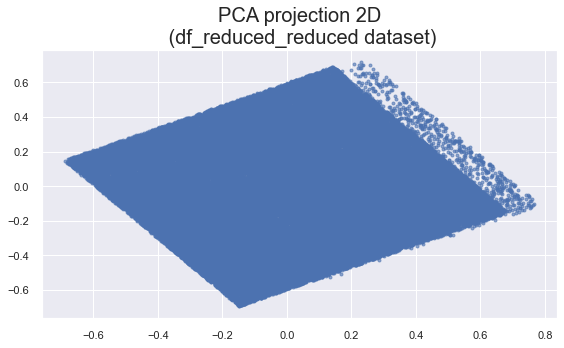

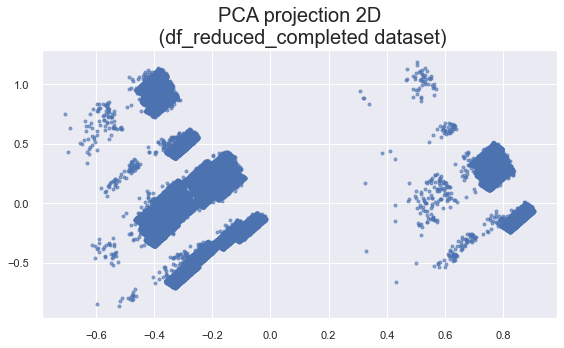

In [18]:
for key, value in DFs_REDUCED.items():
    plt.figure(figsize=(8,5))
    plt.title("PCA projection 2D\n (" + key + " dataset)", size=20)
    plt.scatter(value[:, 0], value[:, 1], alpha=0.6, marker='.')
    plt.tight_layout()
    plt.savefig("images/PCA-projection-2D-" + key + ".png")
    plt.show()
    

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>It seems that there are more defined clusters for all features in comparison with only RFM features</p>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.2. Correlation matrix</h4>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation matrix</b>
</div>

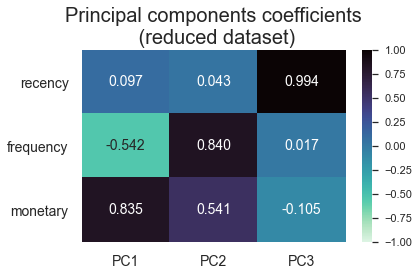

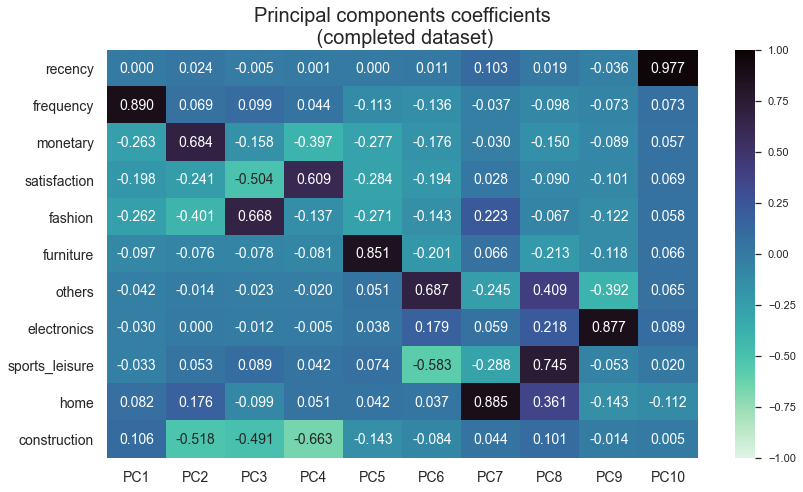

In [19]:
for key, value in DFs_ORIGINAL.items():
    
    if key == "reduced":
        plt.figure(figsize=(6,4))
    else:
        plt.figure(figsize=(12, 7))
        
    plt.title("Principal components coefficients\n (" + key + " dataset)", size=20)
    
    ax = sns.heatmap(globals()["df_pca_" + key], vmin=-1, vmax=1, center=0, cmap="mako_r",
                    annot=True, annot_kws={"size": 14}, fmt=".3f")

    plt.xticks(size=14)
    plt.yticks(rotation=0, size=14)
    plt.tight_layout()
    plt.savefig("images/principal-components-coefficients-" + key + ".png")
    plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>Dataset reduced: </b>Recency and Frequency have a strong relation with PC1. At the same time, Monetary and Satisfaction has a  positive relation with PC2. RFM Score has a strong relation with PC3</li>
        <li><b>Dataset completed: </b>We can see how category are distributed among the differents components. Recency has a strong relation with PC1 and PC2 has a strong relation with the product weight and volume</li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.3. Scree of eigenvalues</h4>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Scree of eigenvalues</b>
</div>

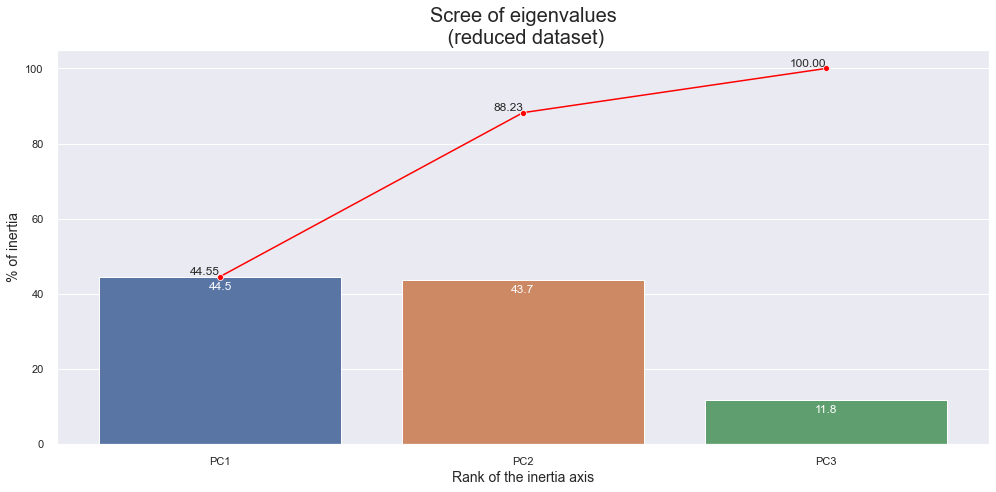

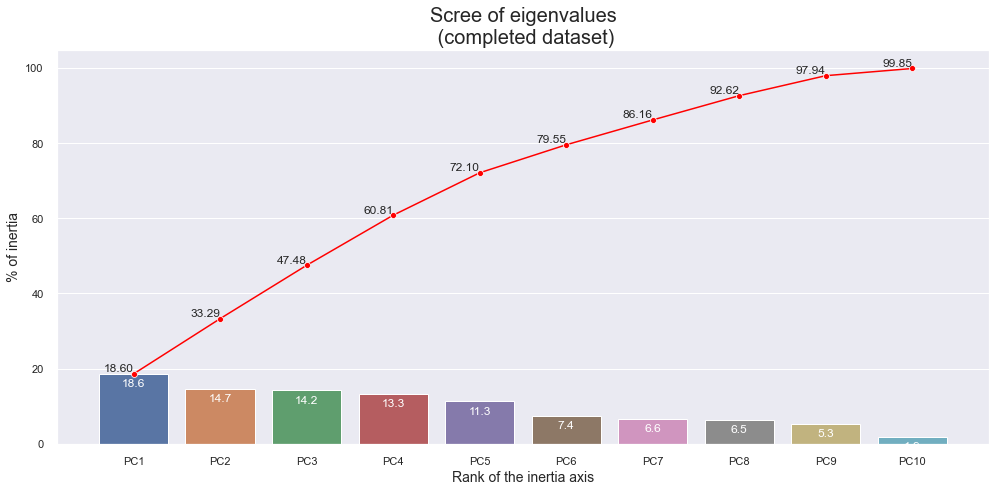

In [20]:
for key, value in DFs_ORIGINAL.items():
    
    scree = globals()["pca_" + key].explained_variance_ratio_*100

    fig = plt.subplots(figsize=(14, 7))
    plot_bar = sns.barplot(x=globals()["df_pca_" + key].columns, y=scree)
    for p in plot_bar.patches:
        plot_bar.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha="center", va="bottom", xytext=(0, -15), textcoords="offset points", color="white")
    plot_line = sns.lineplot(x=globals()["df_pca_" + key].columns, y=scree.cumsum(), marker="o", color="red")

    for x, y in zip(globals()["df_pca_" + key].columns, scree.cumsum()):
        plot_line.text(x, y, "{:.2f}".format(y), ha="right", va="bottom")

    plt.xlabel("Rank of the inertia axis", size=14)
    plt.ylabel("% of inertia", size=14)
    plt.title("Scree of eigenvalues\n (" + key + " dataset)", size=20)
    plt.tight_layout()
    plt.savefig("images/scree-of-eigenvalues-" + key + ".png")
plt.show()

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>Dataset reduced: </b>PC3 has the 89.29% of the data variance.</li>
        <li><b>Dataset completed: </b>PC9 has the 90.58% of the data variance.</li>
    </ul> 
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.4. Correlation Circle</h4>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation Circle</b> for <b>dataset reduced</b>
</div>

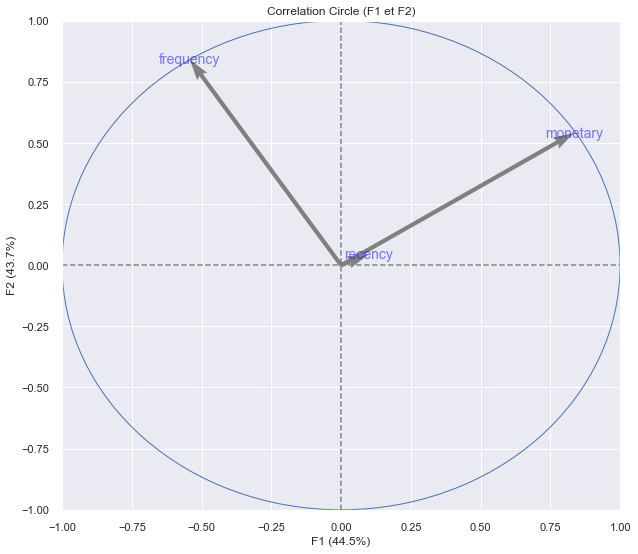

In [21]:
display_circles(pca_reduced.components_, n_comp_reduced, pca_reduced, [(0,1),(2,3),(4,5)], labels=np.array(features_reduced))

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation Circle</b> for <b>dataset completed</b>
</div>

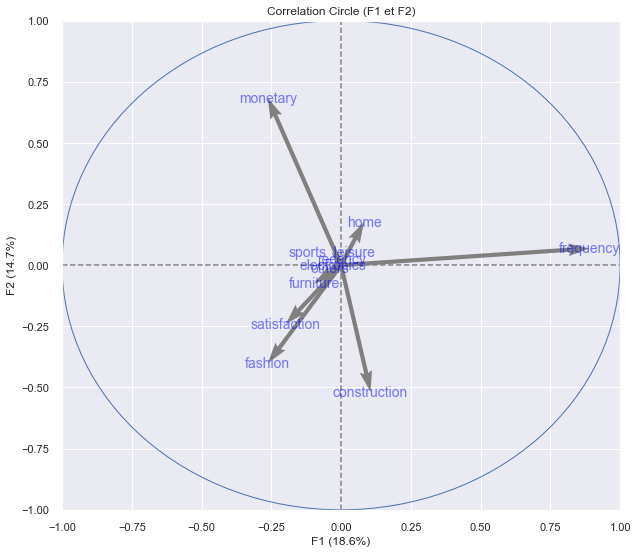

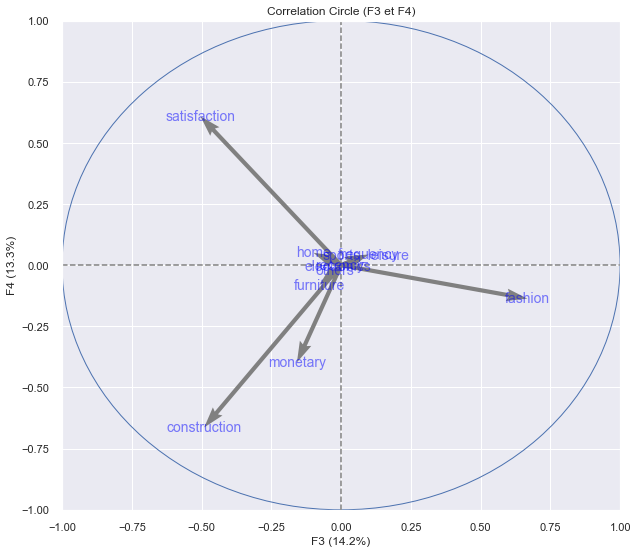

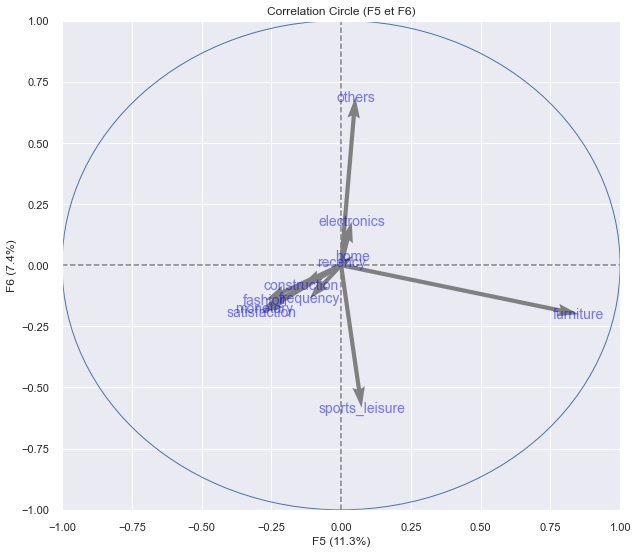

In [22]:
display_circles(pca_completed.components_, n_comp_completed, pca_completed, [(0,1),(2,3),(4,5)], labels=np.array(features_completed))

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.5. Projection of individuals</h4>
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Projection of individuals</b>
</div>

In [23]:
for key, value in DFs_ORIGINAL.items():
    
    globals()["X_projected_" + key] = globals()["pca_" + key].transform(globals()["X_" + key])
    globals()["index_values_sample_" + key] = pd.Series(globals()["index_values_" + key]).sample(10000)

<div class="alert alert-block alert-info">
    Plotting the Projection of individuals for <b>dataset reduced</b></b>
</div>

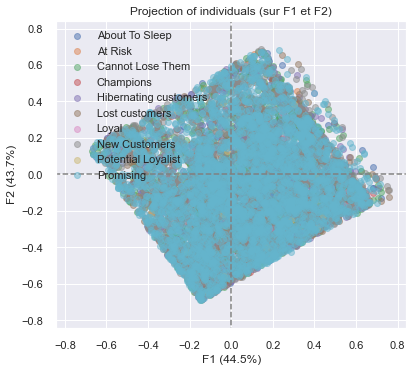

In [24]:
display_factorial_planes(X_projected_reduced, n_comp_reduced, pca_reduced, [(0,1),(2,3),(4,5)], 
                         labels=np.array(index_values_sample_reduced), 
                         illus_var=df_data.loc[index_values_sample_reduced, "rfm_score_label"], 
                         lab_on=False, alpha = 0.5)

<div class="alert alert-block alert-info">
    Plotting the Projection of individuals for <b>dataset completed</b></b>
</div>

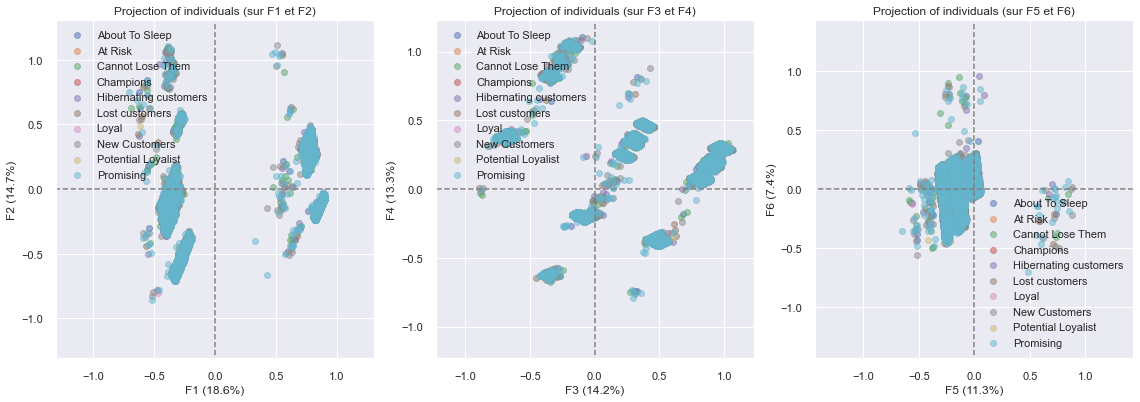

In [25]:
display_factorial_planes(X_projected_completed, n_comp_completed, pca_completed, [(0,1),(2,3),(4,5)], 
                         labels=np.array(index_values_sample_completed), 
                         illus_var=df_data.loc[index_values_sample_completed, "rfm_score_label"], 
                         lab_on=False, alpha=0.5)

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2.6. Variance of the components</h4>
</div>

<div class="alert alert-block alert-info">
    Keeping the <b>90% of the variance of the components</b>
</div>

In [26]:
var_threshold=0.90

for key, value in DFs_ORIGINAL.items():
    
    # Processing the PCA
    globals()["pca_" + key] = decomposition.PCA()
    globals()["pca_" + key].fit(globals()["X_" + key])
    
    # Getting the explained variance ratio for each principal component
    globals()["scree_" + key] = globals()["pca_" + key].explained_variance_ratio_
    
    # Getting the number of principal components to reach variance thresholds
    globals()["mask_" + key] = globals()["scree_" + key].cumsum() > var_threshold
    globals()["nb_selected_components_" + key] = len(globals()["scree_" + key][~globals()["mask_" + key]]) + 1
    
    # Compute and displays the actual ratio of explained variance
    globals()["explained_variance_sum_" + key] = globals()["scree_" + key].cumsum()[globals()["nb_selected_components_" + key]-1]

    # Getting the projection of the data on the first components
    globals()["X_PCA_" + key] = globals()["pca_" + key].transform(globals()["X_" + key])[:,:globals()["nb_selected_components_" + key]]

    
    COL_TO_PC =  ["PC" + str(i + 1) for i in range(globals()["nb_selected_components_" + key])]
    globals()["df_pca_" + key] = pd.DataFrame(data=globals()["X_PCA_" + key], columns=COL_TO_PC, index=globals()["index_values_" + key])
    
    DFs_PCA["df_pca_" + key] = globals()["df_pca_" + key]
    
    print("-- Dataset " + key + " components --")
    print("Number of selected components:", globals()["nb_selected_components_" + key])
    print("Cumulative explained variance:  {:.2f}%".format(globals()["explained_variance_sum_" + key]*100))
    print("Shape: " + str(globals()["df_pca_" + key].shape))
    print("\n")


-- Dataset reduced components --
Number of selected components: 3
Cumulative explained variance:  100.00%
Shape: (66934, 3)


-- Dataset completed components --
Number of selected components: 8
Cumulative explained variance:  92.62%
Shape: (66934, 8)




<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Datasets to works</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to work with 4 datasets</p>
    <ul style="list-style-type: disc;">
        <li><b>scaled_data_completed: </b>All features transformed</li>
        <li><b>scaled_data_reduced: </b>only 3 feautures (RFM) transformed</li>
        <li><b>df_pca_completed: </b>PCA all features</li>
        <li><b>df_pca_reduced: </b>PCA only 3 features (RFM) transformed</li>
    </ul> 
</div>

In [27]:
for key, value in DFs_SCALED.items():
    print("-- " + key + " " + str(value.shape) + " --")
    display(value.head())

-- df_sample_scaled_reduced (66934, 3) --


,recency,frequency,monetary
0,0.0,0.001001,0.082583
1,0.0,0.002002,0.285953
2,0.0,0.008509,0.005189
3,0.0,0.015516,0.902495
4,0.0,0.015516,0.630678


-- df_sample_scaled_completed (66934, 11) --


,recency,frequency,monetary,satisfaction,fashion,furniture,others,electronics,sports_leisure,home,construction
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.001001,0.082583,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.002002,0.285953,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.008509,0.005189,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.015516,0.902495,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.015516,0.630678,1.0


In [28]:
for key, value in DFs_PCA.items():
    print("-- " + key + " " + str(value.shape) + " --")
    display(value)

-- df_pca_reduced (66934, 3) --


,PC1,PC2,PC3
0,-0.080201,-0.645925,0.012109
1,0.089005,-0.535138,-0.009248
2,-0.148869,-0.681458,0.020367
3,0.596293,-0.190470,-0.073818
4,0.369414,-0.337419,-0.045252
...,...,...,...
66929,-0.396433,0.302956,0.001939
66930,-0.484030,0.264107,0.012193
66931,0.394182,0.164551,-0.069424
66932,0.390904,0.229801,-0.071931


-- df_pca_completed (66934, 8) --


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.256939,-0.537006,-0.689141,0.332168,-0.335178,0.133959,-0.205743,-0.518647
1,-0.240251,-0.501066,-0.709152,0.342512,-0.326526,0.140958,-0.026008,-0.444583
2,-0.263552,-0.550268,-0.680824,0.328561,-0.337889,0.126697,-0.276416,-0.540956
3,-0.190008,-0.391557,-0.768885,0.374309,-0.299525,0.156066,0.515860,-0.212246
4,-0.212357,-0.439523,-0.742020,0.360539,-0.310990,0.145932,0.275248,-0.310239
...,...,...,...,...,...,...,...,...
66929,-0.167398,-0.276171,-0.201124,-0.303997,0.881740,-0.427463,-0.225608,0.169888
66930,-0.175724,-0.292180,-0.190379,-0.308191,0.878831,-0.439765,-0.314203,0.146753
66931,-0.307468,0.151686,-0.244178,1.055778,-0.125120,0.003073,0.374451,-0.001677
66932,-0.271768,-0.010320,-0.404223,0.841043,-0.166862,-0.056360,0.401695,0.085752


<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. K-Means</h2>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Number of Cluster</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to identify the number of cluster through</p>
    <ul style="list-style-type: disc;">
        <li><b>Within-Cluser-Sum of Squared Errors</b></li>
        <li><b>Davies-Bouldin score</b></li>
        <li><b>Silhouette score</b></li>
    </ul> 
</div>

for key, value in DFs_SCALED.items():
    number_of_cluster(value, key)

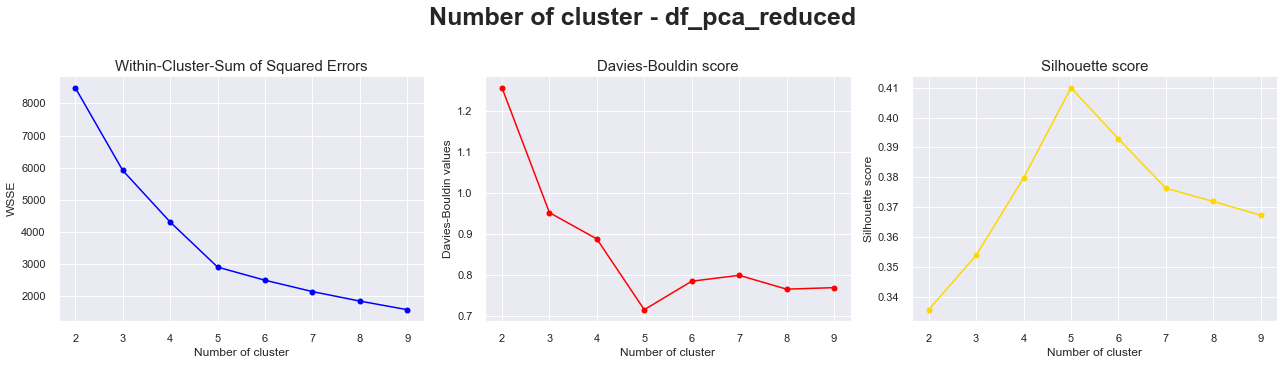

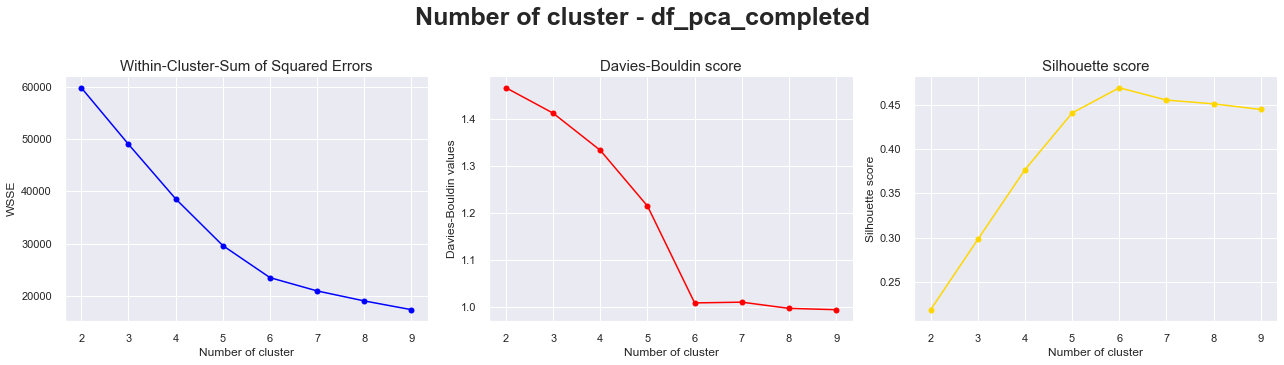

In [31]:
for key, value in DFs_PCA.items():
    number_of_cluster(value, key)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li>For all dataset, the <b>Within-Cluster-Sum of Squared Errors</b> is pretty similar. Unfortunaltely, it seems a little ambiguous </li>
        <li>For the rest, we can see <b>Davies-Bouldin score</b> and <b>Silhouette score</b> have similar results. At the same time <b>PCA datasets</b> get better results in comparison with only scaled data</li>
    </ul> 
    <p>For now, we are going to work with <b>Silhouette score</b> because it is the most informative, and we are going to work with the number of cluster higher or close to 1</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.2. Silhouette analysis</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Let's go deeper into the Silhoutte analysis</p>
    <p>We are only going to use the PCA datasets because they got better result in comparison with scaled datasets</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.33563631557297074
For n_clusters = 3 The average silhouette_score is : 0.3538251968002087
For n_clusters = 4 The average silhouette_score is : 0.37973889073376726
For n_clusters = 5 The average silhouette_score is : 0.40996330721253543
For n_clusters = 6 The average silhouette_score is : 0.3829663019822983
For n_clusters = 7 The average silhouette_score is : 0.3767936640626699
For n_clusters = 8 The average silhouette_score is : 0.3746545235198747
For n_clusters = 9 The average silhouette_score is : 0.36725930167164783


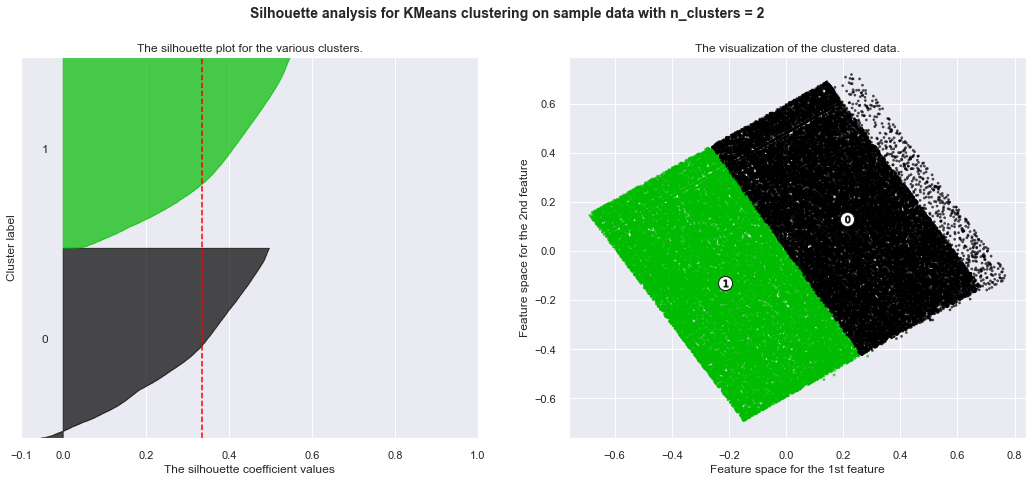

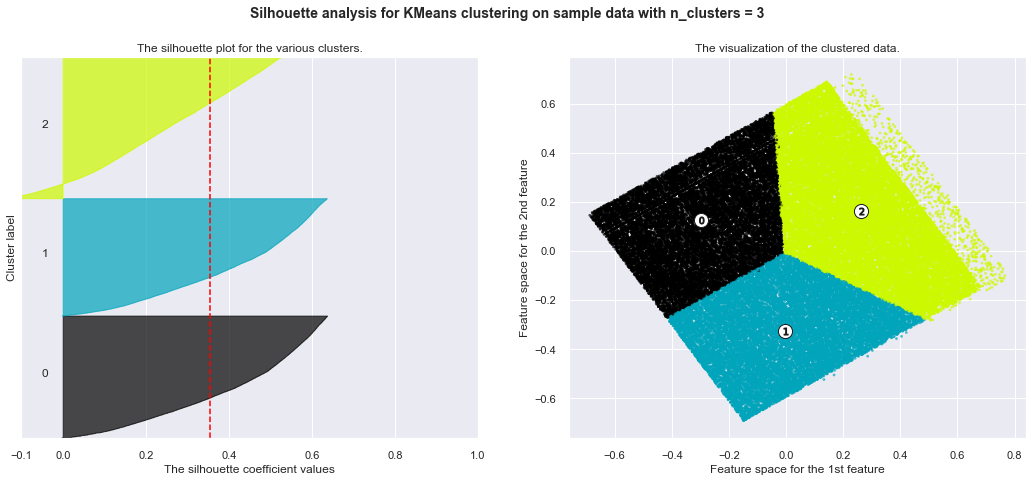

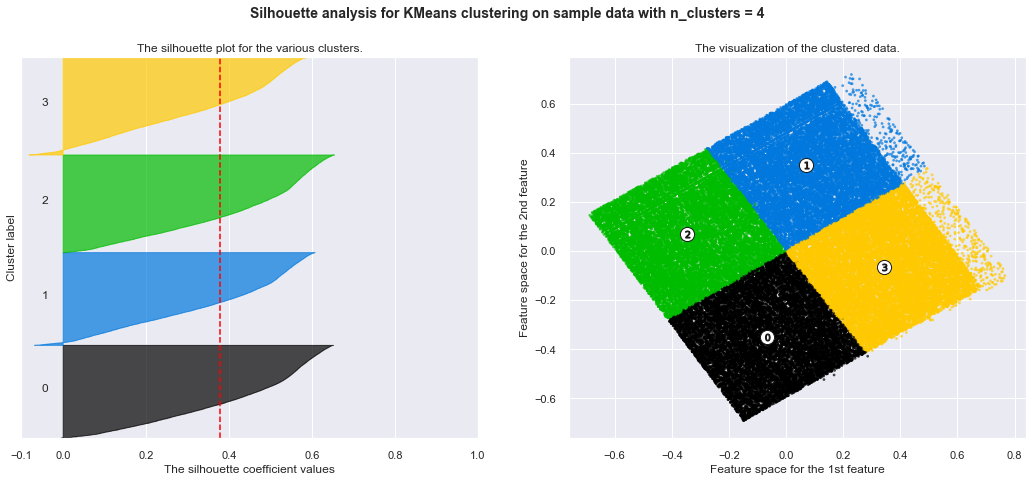

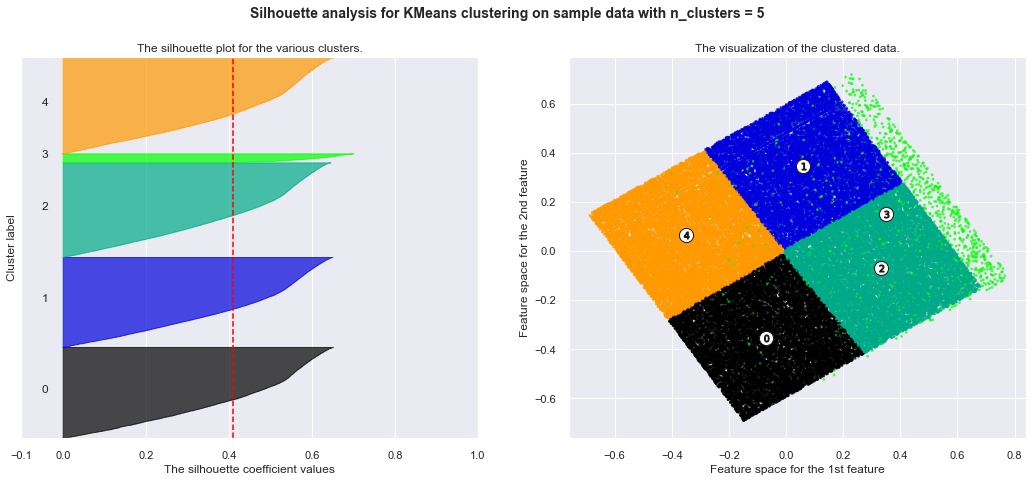

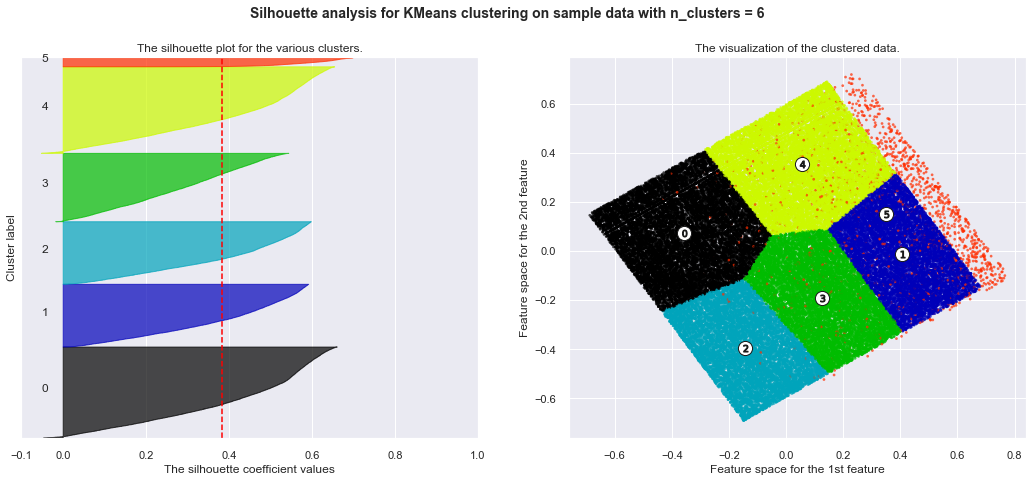

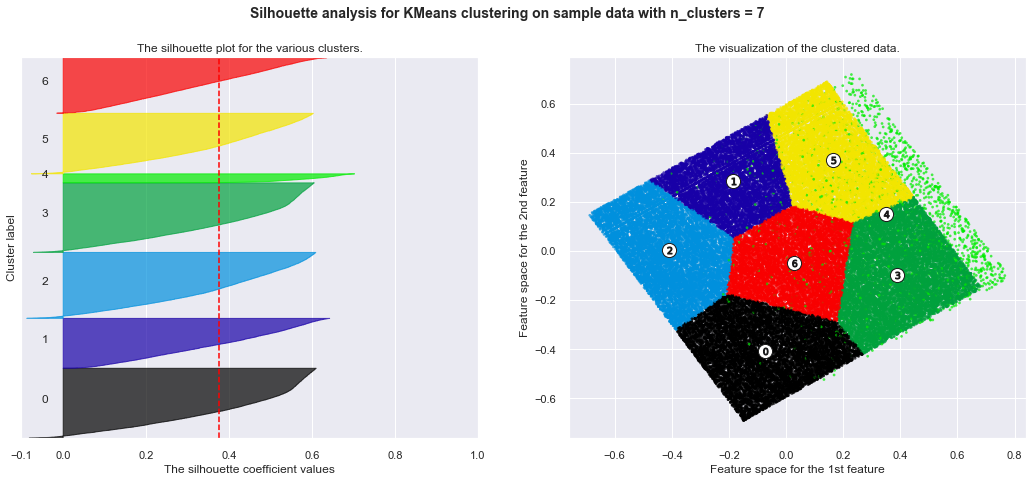

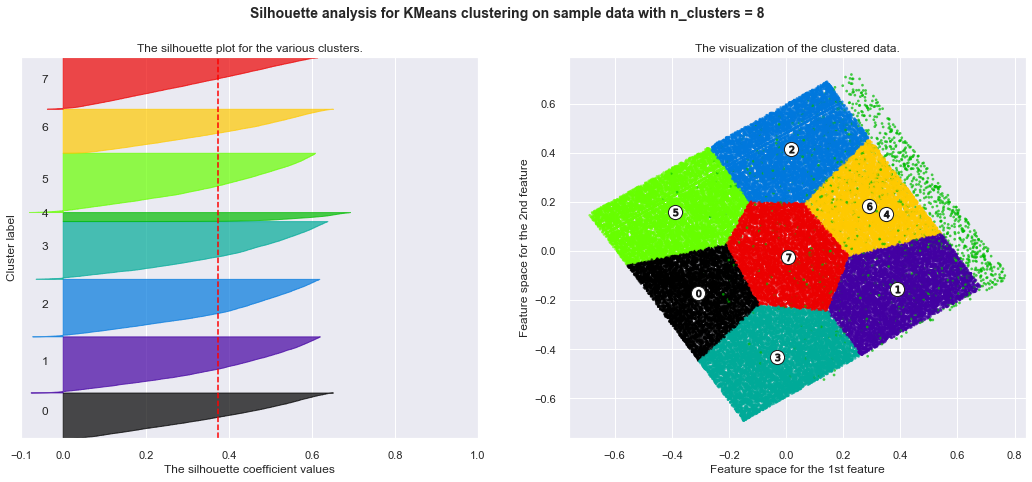

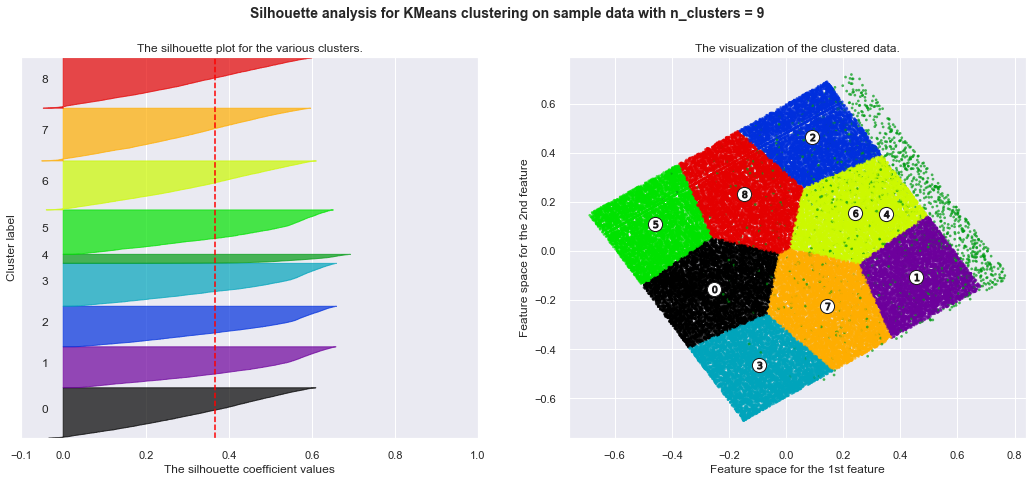

In [32]:
silhoutte_analysis(df_reduced_reduced)

For n_clusters = 2 The average silhouette_score is : 0.2033627431077254
For n_clusters = 3 The average silhouette_score is : 0.2851277711972491
For n_clusters = 4 The average silhouette_score is : 0.3628293503687262
For n_clusters = 5 The average silhouette_score is : 0.43363500639639924
For n_clusters = 6 The average silhouette_score is : 0.48393368040622625
For n_clusters = 7 The average silhouette_score is : 0.5170856562367591
For n_clusters = 8 The average silhouette_score is : 0.47895620288055823
For n_clusters = 9 The average silhouette_score is : 0.4708862245179952


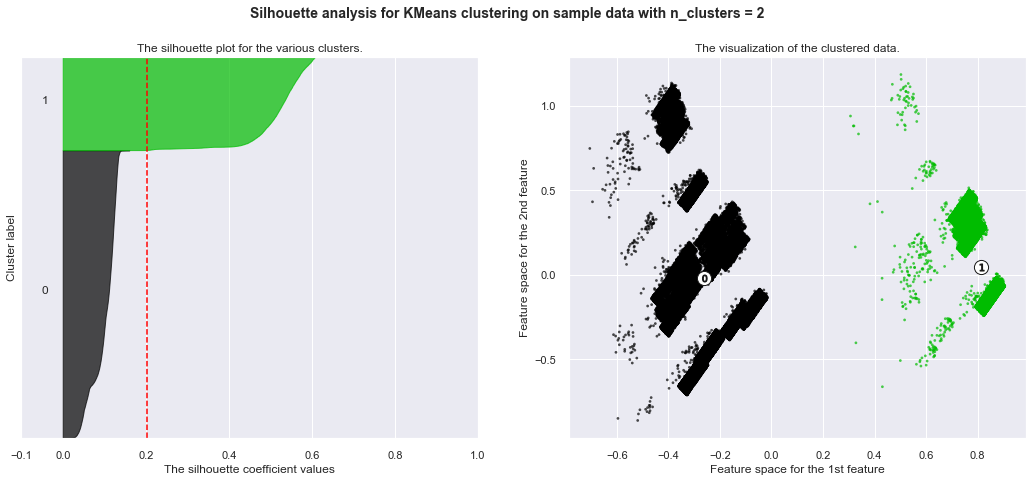

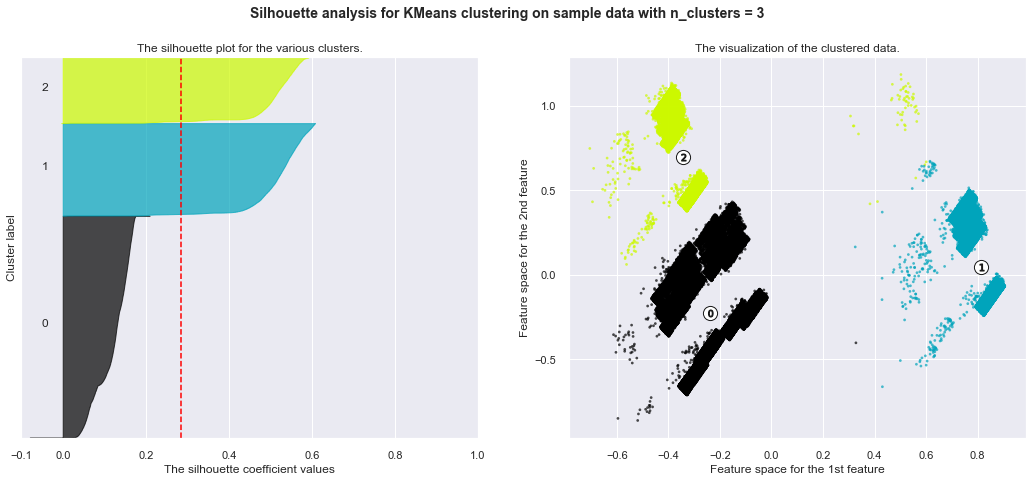

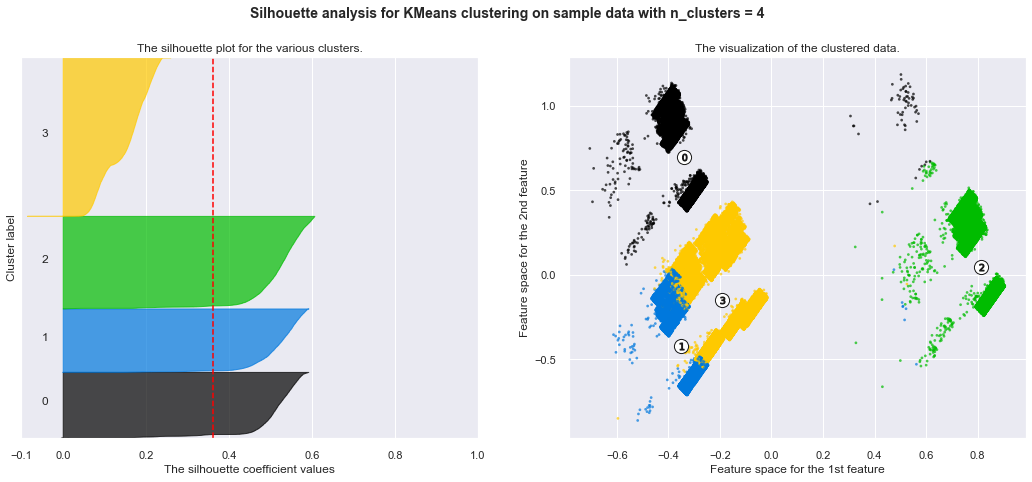

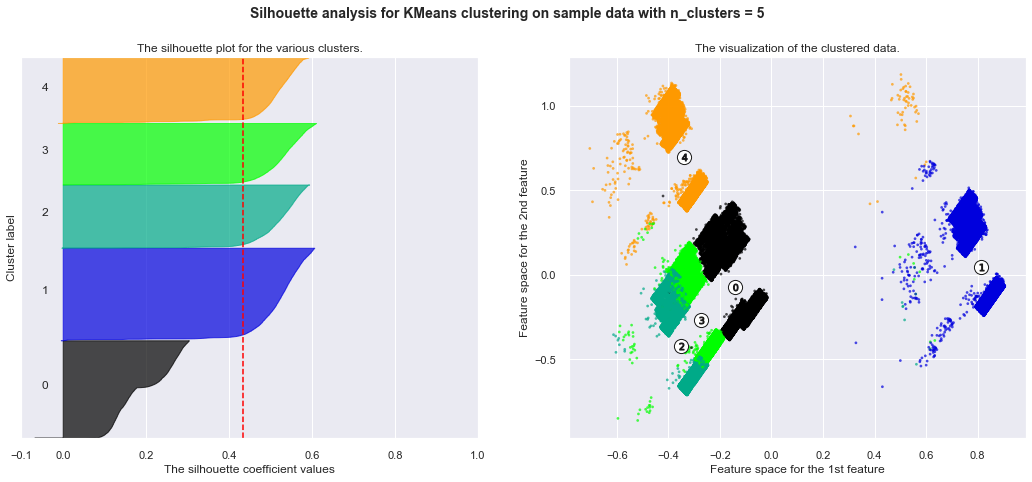

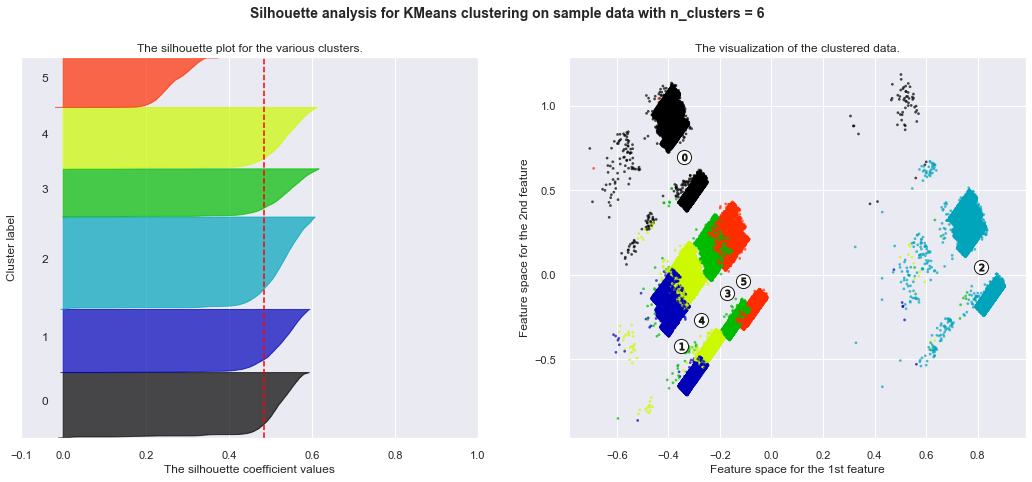

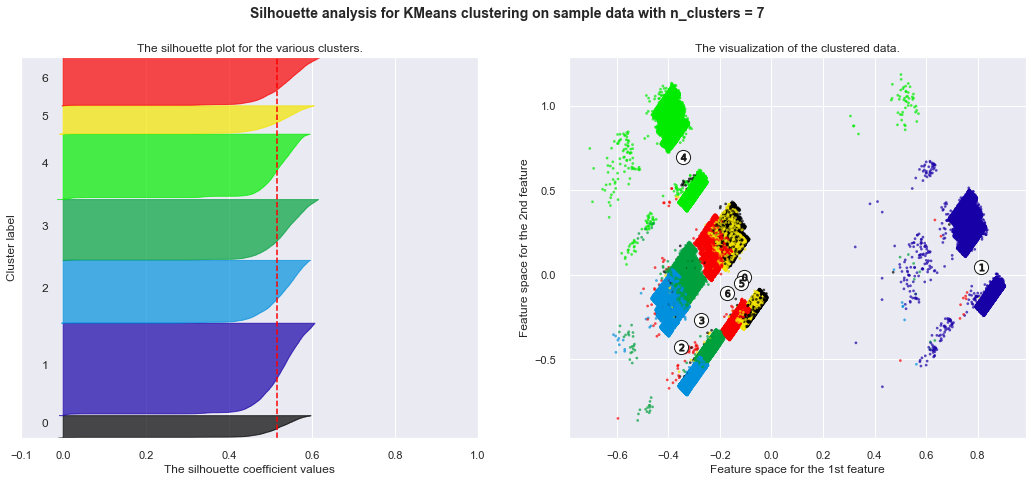

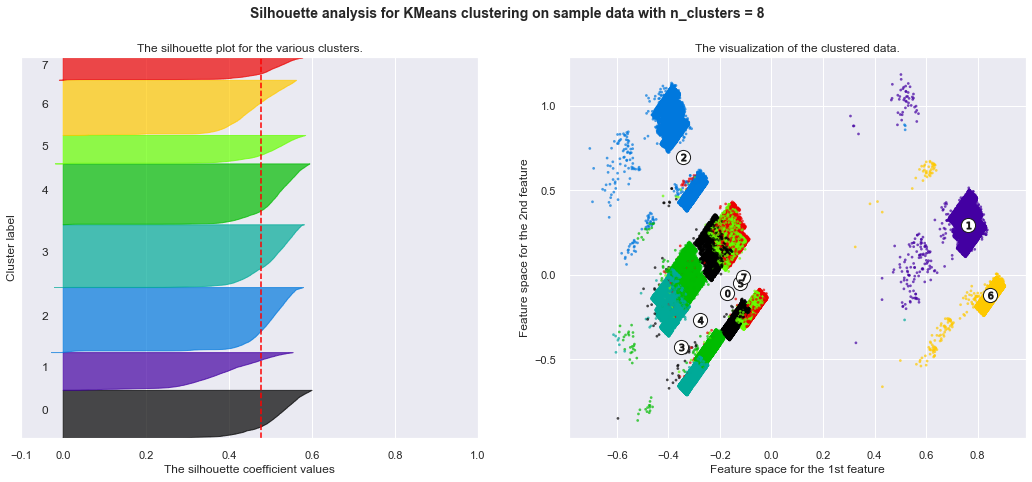

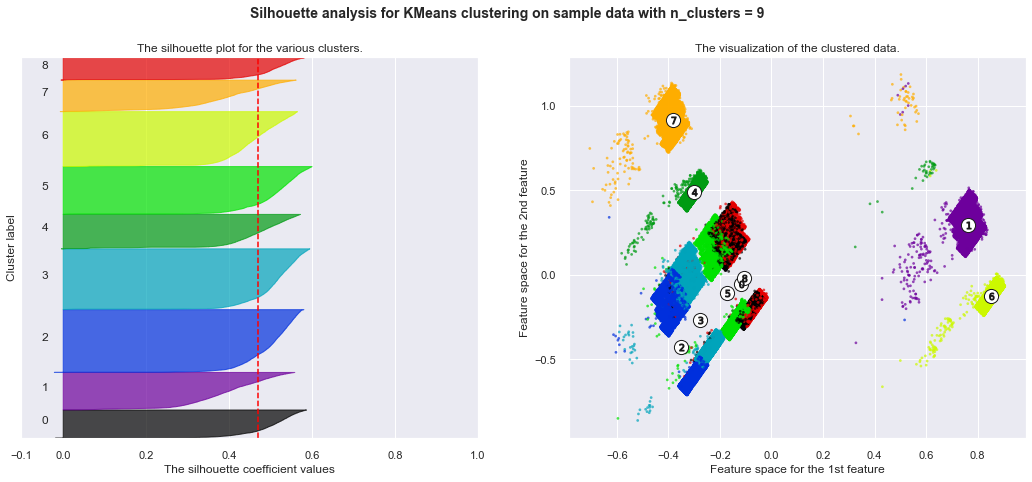

In [33]:
silhoutte_analysis(df_reduced_completed)

In [ ]:
XXXXXXX

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: disc;">
        <li><b>PCA reduced</b> The best score is for n_clusters = 3 The average silhouette_score is : 0.5806691393143009</li>
        <li><b>PCA completed</b> The best score is for n_clusters = 9 The average silhouette_score is : 0.3214506032065177</li>
    </ul> 
    <p>So now, we get that the reduced PCA dataset has a better score than the completed PCA dataset.</p>
    <p>At the same time we can see the clusters more clearly in the first one.</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.3. Intercluster Distance Maps</h3>
</div>

<div class="alert alert-block alert-info">
    <p>Now, we are going to use the best score to plot the intercluster distance</p>
</div>

<div class="alert alert-block alert-info">
    <p><b>PCA reduced</b></p>
</div>

In [ ]:
intercluster_distance(KMeans(3, random_state=42), reduced_data_pca_reduced, 
                      size=(672, 384), title="KMeans Intercluster Distance Map (via MDS)\nPCA reduced"
                     )

<div class="alert alert-block alert-info">
    <p><b>PCA completed</b></p>
</div>

In [ ]:
intercluster_distance(KMeans(9, random_state=42), reduced_data_pca_reduced,
                      size=(672, 384), title="KMeans Intercluster Distance Map (via MDS)\nPCA completed"
                     )

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>We can confirm that <b>the reduced PCA dataset</b> has more clearly clusters and well separated each other as well.</p>
    <p>So, we can see that <b>the reduced PCA dataset</b> is the best option for now.</p>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.4. Parallel Coordinates Plot</h3>
</div>

In [ ]:
df_pca_reduced_parallel_plot = df_pca_reduced.copy()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42).fit(reduced_data_pca_reduced)
kmeans.labels_

In [ ]:
df_pca_reduced_parallel_plot["ID"] = df_sample_scaled_reduced.index
df_pca_reduced_parallel_plot["Cluster"] = kmeans.labels_

In [ ]:
df_pca_reduced_parallel_plot.head()

In [ ]:
df_reduced_melt = pd.melt(df_pca_reduced_parallel_plot.reset_index(),
                          id_vars=["ID", "Cluster"],
                          value_vars=["PC1", "PC2", "PC3"],
                          var_name="Attribute",
                          value_name="Value")

df_reduced_melt.head()

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))
plt.title("Parallel Coordinates Plot for the Cluster\n(PCA reduced)", size=20)
sns.lineplot(x="Attribute", y="Value", hue="Cluster", data=df_reduced_melt, ax=ax1)
ax1.legend(loc="best", borderaxespad=1, title="Clusters")
plt.tight_layout()
plt.show()
plt.savefig("images/parallel-coordinates-plot-pca-reduced.png")
sns.despine(fig)

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>To analyse this graph, it is necessary to remember the PCA Correlation matrix</p>
    
    <ul style="list-style-type: disc;">
        <li><b>Dataset reduced: </b>Recency and Frequency have a strong relation with PC1. At the same time, Monetary and Satisfaction has a  positive relation with PC2. RFM Score has a strong relation with PC3</li>
    </ul>
    <p>So, we can say the following:</p>
    <ul style="list-style-type: disc;">
        <li><b>Cluster 0: </b> has many Recency (PC1), Monetary and Satisfaction (PC2)</li>
        <li><b>Cluster 1: </b> has fewer Recency (PC1)</li>
        <li><b>Cluster 2: </b> has Recency (PC1)</li>
    </ul>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">REFERENCES</h2>
</div>

1. Silhouette Analysis vs Elbow Method vs Davies-Bouldin Index: Selecting the optimal number of clusters for KMeans clustering
    - https://gdcoder.com/silhouette-analysis-vs-elbow-method-vs-davies-bouldin-index-selecting-the-optimal-number-of-clusters-for-kmeans-clustering/

2. Selecting the number of clusters with silhouette analysis on KMeans clustering
    - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

3. Clustering metrics better than the elbow-method
    - https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6

In [ ]:
df_sample_scaled_reduced.head()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5.1. Evaluation benchmark of Cluster</h3>
</div>

In [ ]:
    # Fitting KMeans
km = KMeans(n_clusters=3, random_state=42)

# Prediction
label = km.fit_predict(df_sample_scaled_reduced)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_sample_scaled_reduced.iloc[label==i, 0], df_sample_scaled_reduced.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:
for key, value in DFS.items():
    print(value[0])
    
    # Fitting KMeans
    km = KMeans(n_clusters=value[0], random_state=42)

    # Prediction
    label = km.fit_predict(df_sample_scaled_reduced)
    centroids = km.cluster_centers_
    u_labels = np.unique(label)

    # Graphical representation
    plt.figure(figsize=(10, 10))
    for i in u_labels:
        plt.scatter(df_sample_scaled_reduced.iloc[label==i, 0], df_sample_scaled_reduced.iloc[label==i, 1], label = i)
    plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
    plt.legend()
    plt.title('Représentation des clusters du K-Means')
    plt.show()

In [ ]:
XXXXXXXXXXXXXX

In [ ]:
reduced_data_pca_reduced

In [ ]:
scaled reduced = 3 
sclaled completed = 2 3 2

In [ ]:
pca_completed

In [ ]:
DFs_SCALED

In [ ]:
import matplotlib.pyplot as plt

# reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=3, n_init=4)
kmeans.fit(reduced_data_pca_completed)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data_pca_completed[:, 0].min() - 1, reduced_data_pca_completed[:, 0].max() + 1
y_min, y_max = reduced_data_pca_completed[:, 1].min() - 1, reduced_data_pca_completed[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation="nearest",
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired, aspect="auto", origin="lower")

plt.plot(reduced_data_pca_completed[:, 0], reduced_data_pca_completed[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
            color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

<div class="alert alert-block alert-info">
    <p>Now, we are going to evaluate different initializations methods for KMeans based on the previous number of clusters</p>
</div>

In [ ]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = kmeans.fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]
    
    
    
        
    start_time_model = timeit.default_timer()
    estimator = kmeans.fit(data)
    end_time_model =  round(timeit.default_timer() - start_time_model, 3)
    results = [name, end_time_model, estimator[-1].inertia_]
    
    
    

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(data, estimator[-1].labels_,
                                 metric="euclidean", sample_size=300,)
    ]

    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

<div class="alert alert-block alert-success">
    <p>---------------------------</p>
</div>

In [ ]:
DFS = [df_sample_scaled_reduced, df_sample_scaled_completed, df_pca_reduced, df_pca_completed]

for k in DFS:
    print(str(k.shape))

In [ ]:
DFS = {
    "scaled_reduced" : [3, df_sample_scaled_reduced],
    "scaled_completed" : [2, df_sample_scaled_completed],
    "pca_reduced" : [3, df_pca_reduced],
    "pca_completed" : [9, df_pca_completed],
}

In [ ]:
for key, value in DFS.items():
    print(value[0])
    
    # Fitting KMeans
    km = KMeans(n_clusters=value[0], random_state=42)

    # Prediction
    label = km.fit_predict(df_sample_scaled_reduced)
    centroids = km.cluster_centers_
    u_labels = np.unique(label)

    # Graphical representation
    plt.figure(figsize=(10, 10))
    for i in u_labels:
        plt.scatter(df_sample_scaled_reduced.iloc[label==i, 0], df_sample_scaled_reduced.iloc[label==i, 1], label = i)
    plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
    plt.legend()
    plt.title('Représentation des clusters du K-Means')
    plt.show()

<div class="alert alert-block alert-success">
    <p>---------------------------</p>
</div>

In [ ]:
for key, value in DFs_PCA.items():
    print(key)

In [ ]:
df_pca_completed

In [ ]:

# Fitting KMeans
km = KMeans(n_clusters=3, random_state=42)

# Prediction
label = km.fit_predict(df_sample_scaled_reduced)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_sample_scaled_reduced.iloc[label==i, 0], df_sample_scaled_reduced.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:

# Fitting KMeans
km = KMeans(n_clusters=2, random_state=42)

# Prediction
label = km.fit_predict(df_sample_scaled_completed)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_sample_scaled_completed.iloc[label==i, 0], df_sample_scaled_completed.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:

# Fitting KMeans
km = KMeans(n_clusters=3, random_state=42)

# Prediction
label = km.fit_predict(df_pca_reduced)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_pca_reduced.iloc[label==i, 0], df_pca_reduced.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:

# Fitting KMeans
km = KMeans(n_clusters=9, random_state=42)

# Prediction
label = km.fit_predict(df_pca_completed)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_pca_completed.iloc[label==i, 0], df_pca_completed.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:
for key, value in DFs_PCA.items():
    print(value.shape)

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
WSSE, davies_bouldin, silhouette = ({} for i in range(3))

for key, value in DFS_TO_WORK.items():
    
    print(key)
    
    for i in range(2, 10):
        
        # seed of 10 for reproducibility.
        kmeans = KMeans(init='k-means++', n_clusters=i, max_iter=1000, random_state=10).fit(value)
        
        clusters = kmeans.labels_
        WSSE[i] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
        davies_bouldin[i] = davies_bouldin_score(value, clusters)
        silhouette[i] = silhouette_score(value, clusters)

In [ ]:
# Graphiques pour chaque métriques

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25, 5))

ax1.plot(list(WSSE.keys()), list(WSSE.values()), color="blue", marker='o')
ax1.set_xlabel("Number of cluster")
ax1.set_ylabel("WSSE")

ax2.plot(list(davies_bouldin.keys()), list(davies_bouldin.values()), color="red", marker='o')
ax2.set_xlabel("Number of cluster")
ax2.set_ylabel("Davies-Bouldin values")

ax3.plot(list(silhouette.keys()), list(silhouette.values()), color="gold", marker='o')
ax3.set_xlabel("Number of cluster")
ax3.set_ylabel("Silhouette score")

<div class="alert alert-block alert-info">
    Now, we are going to select the number of cluster through the <b>Elbow Method</b>
</div>

In [ ]:
model = KMeans()

for key, value in DFS_TO_WORK.items():
    
    visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
    
    print("\n-- " + key + " --\n")
    
    visualizer.fit(value)
    visualizer.show()
    
    print("\n")

In [ ]:

# Fitting KMeans
km = KMeans(n_clusters=7, random_state=42)

# Prediction
label = km.fit_predict(data_pca_reduced)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(data_pca_reduced[label==i, 0], data_pca_reduced[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:

# Fitting KMeans
km = KMeans(n_clusters=4, random_state=42)

# Prediction
label = km.fit_predict(data_sample_scaled_reduced)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(data_sample_scaled_reduced[label==i, 0], data_sample_scaled_reduced[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:

# Fitting KMeans
km = KMeans(n_clusters=7, random_state=42)

# Prediction
label = km.fit_predict(data_sample_scaled_completed)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(data_sample_scaled_completed[label==i, 0], data_sample_scaled_completed[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:
CCCCC

In [ ]:
DICTIONARY_DFS = {
    "reduced" : data_reduced,
    "completed" : data_completed    
}

In [ ]:
sample_scaled_reduced

In [ ]:
sample_scaled_completed

In [ ]:
example = globals()["sample_scaled_" + key] = preprocessor.fit_transform(value)

In [ ]:
data_reduced

In [ ]:
example = preprocessor.fit_transform(data_reduced)

In [ ]:
data_reduced

In [ ]:
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=K)
    km = km.fit(df_pca_reduced.values)
    sum_of_squared_distances.append(km.inertia_)

In [ ]:
df_pca_completed

In [ ]:
# Run a number of tests, for 1, 2, ... num_clusters
num_clusters = 50
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(df_pca_completed.values).score(df_pca_completed.values) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [ ]:
model = KMeans()

    
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(sample_scaled_completed)
visualizer.show()


In [ ]:
model = KMeans()

    
visualizer = KElbowVisualizer(model, k=(2, 50), timings=False)
visualizer.fit(sample_scaled_reduced)
visualizer.show()


<div class="alert alert-block alert-info">
    Now, we are going to select the number of cluster through the <b>Elbow Method</b>
</div>

In [ ]:
model = KMeans()

for key, value in DICTIONARY_DFS.items():
    
    visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
    
    if ("pca") in key:
        print("\n-- " + key + " --\n")
        visualizer.fit(globals()["df_" + key])
    else:
        print("\n-- " + key + " --\n")
        visualizer.fit(globals()["df_pca_" + key])
        
    visualizer.show()
    
    print("\n")

<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>Now, we got the cluster for each dataset</p>
</div>

In [ ]:
# Fitting KMeans
km = KMeans(n_clusters=4, random_state=42)

# Prediction
label = km.fit_predict(df_pca_reduced.value)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_pca_reduced[label==i, 0], df_pca_reduced[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:
# Fitting KMeans
km = KMeans(init='random', n_clusters=5, random_state=42,  n_init=10)

In [ ]:
km.fit(df_pca_reduced)
clusters = km.predict(df_pca_reduced)

In [ ]:
pca_reduced = PCA(n_components=3)
pca_reduced.fit(df_pca_reduced)

In [ ]:
X_reduced = pca_reduced.transform(df_pca_reduced)

In [ ]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(X_reduced, index=df_pca_reduced.index, columns=['PC1','PC2', "PC3"])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

In [ ]:
centres_reduced = pca_reduced.transform(km.cluster_centers_)

In [ ]:
display_factorial_planesXXX(X_reduced, 2, pca_reduced, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='r', zorder=10)

In [ ]:
def display_factorial_planesXXX(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)

In [ ]:
data_reduced.index

In [ ]:
# Fitting KMeans
km = KMeans(n_clusters=5, random_state=42)

# Prediction
label = km.fit_predict(df_pca_reduced)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_pca_reduced.iloc[label==i, 0], df_pca_reduced.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [ ]:
# Fitting KMeans
km = KMeans(n_clusters=6, random_state=42)

# Prediction
label = km.fit_predict(df_pca_completed)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_pca_completed.iloc[label==i, 0], df_pca_completed.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

In [ ]:
df 

In [ ]:
df_log = pd.DataFrame({
    "column1":["A", "A", "A", "A", "A", "A", "A"],
    "column2":["B", "B", "B", "B", "B", "B", "B"],
    "column3":[5, 2, 10, 1, 1, 1, 1],
    "column4":[4234, 432, 123, 123, 124, 125, 126],
    "column5":[123, 3243, 43, 45, 23243, 234, 23]
})

In [ ]:
df_log

In [ ]:
df_log["log2"] = np.log2(df_log["column5"] + 1)

In [ ]:
df_log

In [ ]:
df_log["log2-inverse"] = 2 ** df_log["log2"] - 1
df_log

In [ ]:
CCCCCCCCCCCC

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10), timings=False)
visualizer.fit(df_worked)
visualizer.show()

In [ ]:
# Run a number of tests, for 1, 2, ... num_clusters
num_clusters = 50
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(df_worked).score(df_worked) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-info">
    First of all, we are going to work on deafult mode for the model
</div>

In [ ]:
model = KMeans(init="random", n_clusters="4", n_init=10)

In [ ]:
label  = model.fit_predict(df_data_PCA)

In [ ]:
# centroids = model.cluster_centers_
u_labels = np.unique(label)

In [ ]:
# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(df_data_PCA.iloc[label==i, 0], df_data_PCA.iloc[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.1. K-means</h3>
</div>

<div class="alert alert-block alert-info">
    First of all, we are going to work on deafult mode for the model
</div>

In [ ]:
https://www.scikit-yb.org/en/latest/

https://www.youtube.com/watch?v=4b5d3muPQmA
- forma
    -- centroide??
        -- homogeneidad
        -- Separacion de cluster -- SKL=
         union --> index davies bouldin
         silhouette -> escoger la cantidad de cluster y ver la estabilidad
- estabilidad
- coherencia


- ARI, pour Adjusted Rand Index

https://towardsdatascience.com/clustering-algorithms-for-customer-segmentation-af637c6830ac
https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
https://www.youtube.com/watch?v=EItlUEPCIzM
https://datascientest.com/algorithme-des-k-means.
https://realpython.com/k-means-clustering-python/

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

In [ ]:
raise SystemExit("Stop right there!")

<div class="alert alert-block alert-danger">
    <p><b>Flag position</b></p>
</div>

<div style="background-color: #6D83C5;" >
    <h1 style="margin: auto; padding: 20px; color:#fff; ">------------------------------------------</h1>
</div>

<div style="background-color: #6D83C5;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3.2. Optimization</h3>
</div>

<div class="alert alert-block alert-info">
    List of models to use. for now, in default mode
</div>

- Clustering hiérarchique
- k-means
- DBScan

https://www.definitions-marketing.com/definition/segmentation-rfm/<br>
https://lms.simplilearn.com/courses/4414/Introduction-to-Supervised-&-Unsupervised-Machine-Learning/syllabus<br>

https://classroom.udacity.com/courses/st101<br>
https://classroom.udacity.com/courses/ud827<br>
https://www.freecodecamp.org/news/free-machine-learning-course-10-hourse/<br>

https://towardsdatascience.com/10-highly-probable-data-scientist-interview-questions-fd83f7414760<br>